In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sp
import os as os
import multiprocessing
from joblib import Parallel, delayed
from time import time as ti
from skimage.restoration import denoise_wavelet
import pickle
#import CoreFunctions as cf
import sys
import random

In [48]:
DataFolder = '/sciclone/scr10/dchendrickson01/Recordings2/'
DataFolder = '/scratch/Recordings2/'

TIME_STEPS = 1200
Skips = 125
RollSize = 50

tic = ti()
start = tic

MemoryProtection = True
RunTwice = True
FilesPerRun = 16
ConcurrentFiles = 4

In [3]:
def RollingStdDevFaster(RawData, SmoothData, RollSize = 25):

    Diffs = RawData - SmoothData
    del RawData, SmoothData
    
    Sqs = Diffs * Diffs
    del Diffs
    
    Sqs = Sqs.tolist() 
    Sqs.extend(np.zeros(RollSize))
    mSqs = np.matrix(Sqs)
    
    for i in range(RollSize):
        Sqs.insert(0, Sqs.pop())
        mSqs = np.concatenate((np.matrix(Sqs),mSqs))
    
    sVect = mSqs.sum(axis=0)
    eVect = (mSqs!=0).sum(axis=0)
    del mSqs, Sqs
    
    VarVect = sVect / eVect
    StdDevs = np.sqrt(VarVect)
    return np.asarray(StdDevs[:-RollSize].T)

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.02, verbose = False):
    
    SquelchSignal = np.ones(len(DataSet))
    if verbose:
        print(len(SquelchSignal))
        
    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+StallRange]) < SquelchLevel:
            SquelchSignal[i+StallRange]=0

    return SquelchSignal

def split_list_by_zeros(original_list, ones_list):
    # modified split_list_by_ones function to instead split by the zeros.
    #
    #
    # Created with Bing AI support
    #  1st request: "python split list into chunks based on value"
    #  2nd request: "I want to split the list based on the values in a second list.  Second list is all 1s and 0s.  I want all 0s removed, and each set of consequtive ones as its own item"
    #  3rd request: "That is close.  Here is an example of the two lists, and what I would want returned: original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
    #                ones_list =     [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
    #                return: [[1, 2, 3, 8], [4, 5, 6], [8,9]]"
    #
    #This is the function that was created and seems to work on the short lists, going to use for long lists
    
    result_sublists = []
    sublist = []

    for val, is_one in zip(original_list, ones_list):
        if not is_one:
            sublist.append(val)
        elif sublist:
            result_sublists.append(sublist)
            sublist = []

    # Add the last sublist (if any)
    if sublist:
        result_sublists.append(sublist)

    return result_sublists

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS, skips = Skips):
    output = []
    for i in range(int((len(values) - time_steps + skips)/skips)):
        output.append(values[i*skips : (i*skips + time_steps)])
    return np.stack(output)

In [4]:
def runFile(file, verbose = False, small = False, index=0, start=ti()):
    noise = verbose
    if file[-4:] == '.csv':    
        dataset = pd.read_csv(DataFolder+file, delimiter =",", header=None, engine='python',on_bad_lines='skip')
        if noise:
            print("File Read", ti()-start)
        dataset = dataset.rename(columns={0:"Day"})
        dataset = dataset.rename(columns={1:"Second"})
        dataset = dataset.rename(columns={2:"FracSec"})
        dataset = dataset.rename(columns={3:"p"})
        dataset = dataset.rename(columns={4:"h"})
        dataset = dataset.rename(columns={5:"v"})
        dataset = dataset.rename(columns={6:"Sensor"})

        dataset['Second'].replace('',0)
        dataset['FracSec'].replace('',0)
        dataset.replace([np.nan, np.inf, -np.inf],0,inplace=True)
        
        dataset[['Day','Second']] = dataset[['Day','Second']].apply(lambda x: x.astype(int).astype(str).str.zfill(6))
        dataset[['FracSec']] = dataset[['FracSec']].apply(lambda x: x.astype(int).astype(str).str.zfill(4))

        dataset["timestamp"] = pd.to_datetime(dataset.Day+dataset.Second+dataset.FracSec,format='%y%m%d%H%M%S%f')
        dataset["timestamps"] = dataset["timestamp"]

        dataset["p"] = dataset.p - np.average(dataset.p)
        dataset["h"] = dataset.h - np.average(dataset.h)
        dataset["v"] = dataset.v - np.average(dataset.v)
        dataset["r"] = np.sqrt(dataset.p**2 + dataset.h**2 + dataset.v**2)

        dataset.index = dataset.timestamp

        dataset["SmoothP"] = denoise_wavelet(dataset.p, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothH"] = denoise_wavelet(dataset.h, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothV"] = denoise_wavelet(dataset.v, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothR"] = denoise_wavelet(dataset.r, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')

        if noise:
            print("Data Cleaned", ti()-start, len(dataset.p))

        RawData = dataset.v
        SmoothData = dataset.SmoothV
        RollSize = 25

        Diffs = RawData - SmoothData

        Sqs = Diffs * Diffs

        Sqs = Sqs.tolist() 

        Sqs.extend(np.zeros(RollSize))

        mSqs = np.matrix(Sqs)

        for i in range(RollSize):
            Sqs.insert(0, Sqs.pop())
            mSqs = np.concatenate((np.matrix(Sqs),mSqs))

        sVect = mSqs.sum(axis=0)
        eVect = (mSqs!=0).sum(axis=0)

        VarVect = sVect / eVect

        StdDevs = np.sqrt(VarVect)

        StdDevsZ = np.asarray(StdDevs)

        StdDevsZ=np.append(StdDevsZ,[0])

        StdDevsZ = np.asarray(StdDevsZ.T[:len(dataset.p)])

        if noise:
            print("Size StdDevsZ", ti()-start, np.shape(StdDevsZ))

        #StdDevsZ = np.nan_to_num(StdDevsZ)

        #StdDevsZ[StdDevsZ == np.inf] = 0
        #StdDevsZ[StdDevsZ == -np.inf] = 0

        if noise:
            print("cleaned", ti()-start, np.shape(StdDevsZ))

        SmoothDevZ = denoise_wavelet(StdDevsZ, method='VisuShrink', mode='soft', wavelet='sym2', rescale_sigma='True')

        if noise:
            print("denoise 1", ti()-start, np.shape(StdDevsZ))

        #SmoothDevZa = cf.Smoothing(StdDevsZ, 3, wvt='sym2', dets_to_remove=2, levels=3)
        #SmoothDevZ = np.ravel(SmoothDevZ[0,:])

        #SmoothDevZ = SmoothDevZ.tolist()

        if noise:
            print("denoise 2", ti()-start, np.shape(SmoothDevZ))

        #ataset["SmoothDevZ"] = SmoothDevZ

        SmoothDevZ[np.isnan(SmoothDevZ)]=0
        
        Max = np.max(SmoothDevZ)

        
        
        if noise:
            print("Max", ti()-start, np.shape(Max), Max)

        buckets = int(Max / 0.005) + 1
        bins = np.linspace(0,buckets*0.005,buckets+1)
        counts, bins = np.histogram(SmoothDevZ,bins=bins)

        CummCount = 0
        HalfWay = 0
        for i in range(len(counts)):
            CummCount += counts[i]
            if CummCount / len(SmoothDevZ) >= 0.5:
                if HalfWay == 0:
                    HalfWay = i

        SquelchLevel = bins[HalfWay] 
        if noise:
            print("SmoothDevz size", np.shape(SmoothDevZ))

        dataset["IsMoving"] = SquelchPattern(SmoothDevZ, 4000, SquelchLevel, verbose=noise)

        if noise:
            print("Squelch Made", ti()-start)
        #dataset["velocity"] = getVelocity(dataset.p, dataset.FracSec, dataset.IsMoving, 2)
        #if noise:
        #    print("Velocity Calculated.  File done: ",file)

        #df_pr = split_list_by_ones(dataset.p, dataset.IsMoving)
        #df_hr = split_list_by_ones(dataset.h, dataset.IsMoving)
        #df_vr = split_list_by_ones(dataset.v, dataset.IsMoving)
        #df_rrr = split_list_by_ones(dataset.r, dataset.IsMoving)
        df_ps = split_list_by_zeros(dataset.SmoothP, dataset.IsMoving)
        df_hs = split_list_by_zeros(dataset.SmoothH, dataset.IsMoving)
        df_vs = split_list_by_zeros(dataset.SmoothV, dataset.IsMoving)
        df_rs = split_list_by_zeros(dataset.SmoothR, dataset.IsMoving)

        MatsSmooth = []
        for i in range(len(df_ps)):
            MatsSmooth.append(np.vstack((df_ps[i],df_hs[i],df_vs[i],df_rs[i])))
        
        if verbose:
            print("Split by ones", ti()-start)


        '''df_p=[0]
        df_h=[0]
        df_v=[0]
        df_r=[0]
        df_rp=[0]
        df_rh=[0]
        df_rv=[0]
        df_rr=[0]
        for i in range(len(df_ps)):
            df_p += df_ps[i]
            df_h += df_hs[i]
            df_v += df_vs[i]
            df_r += df_rs[i]
            df_rp += df_pr[i]
            df_rh += df_hr[i]
            df_rv += df_vr[i]
            df_rr += df_rrr[i]
        '''
        if verbose:
            print('format changed', ti()-start, len(MatsSmooth))

        return MatsSmooth
    else:
        return ['fail','fail']
        
        #if verbose:
        #    print('Data normalized', ti()-start)

        #return df_p, df_h, df_v, df_r, df_rp, df_rh, df_rv, df_rr


In [5]:
files= os.listdir(DataFolder) 

In [6]:
random.shuffle(files)

In [44]:
%%time
#df_p, df_h, df_v, df_r, 
Mats = runFile(files[4], verbose = True, small = False, index=0, start=ti())

File Read 89.96541023254395
Data Cleaned 152.52360773086548 18938913
Size StdDevsZ 182.5534222126007 (18938913,)
cleaned 182.55360674858093 (18938913,)
denoise 1 183.0108208656311 (18938913,)
denoise 2 183.01099181175232 (18938913,)
Max 183.02360105514526 () 0.2091866506206767
SmoothDevz size (18938913,)
18938913
Squelch Made 269.416303396225
Split by ones 279.37793254852295
format changed 279.37818717956543 473
CPU times: user 4min 20s, sys: 19.1 s, total: 4min 39s
Wall time: 4min 40s


In [45]:
def runWrapper(file, verbose = True, small = False, index=0, start=ti()):
    try:
        rtrn = runFile(file, verbose, small, index, start)
        return rtrn
    except:
        return np.zeros((10,3))

In [49]:
%%time
AllDatas = Parallel(n_jobs=ConcurrentFiles)(delayed(runWrapper)(files[(i+8)*7], False, False, 0, ti()) for i in range(FilesPerRun))

CPU times: user 565 ms, sys: 1.28 s, total: 1.84 s
Wall time: 15min 22s


In [50]:
for fileResponse in AllDatas:
    for Mat in fileResponse:
        Mats.append(Mat)

In [ ]:
%%time
if RunTwice:
    AllDatas = Parallel(n_jobs=ConcurrentFiles)(delayed(runWrapper)(files[(i+8)*7], False, False, 0, ti()) for i in range(FilesPerRun))

In [ ]:
if RunTwice:
    for fileResponse in AllDatas:
        for Mat in fileResponse:
            Mats.append(Mat)

In [51]:
len(Mats)

5097

In [52]:
import CoreFunctions as cf

In [53]:
lengths = []
rejects = []
Keeps = []

In [54]:
for Mat in Mats:
    lenM = np.shape(Mat)[1]
    if (lenM > 1250):
        lengths.append(lenM)
        Keeps.append(Mat)
    else:
        rejects.append(lenM)

In [55]:
if MemoryProtection:
    del Mats, AllDatas


In [56]:
len(lengths) / (len(lengths)+len(rejects))

0.47577006082009027

In [57]:
plt.hist(lengths, bins=20)
plt.xlabel("lengths")
plt.ylabel("No of samples")
plt.show()


In [58]:
Prints = []


In [59]:
np.shape(Keeps[3])

(4, 22438)

In [60]:
def PrintWrap(Mat):
    localPrints = []
    lenm = np.shape(Mat)[1]
    slices = int(lenm/TIME_STEPS)
    for i in range(slices):
        temp = (cf.makeMPFast(Mat[:3,i*TIME_STEPS:(i+1)*TIME_STEPS], wvt = 'sym4', scales = 60, spacer = 1, title = ''))
        localPrints.append(temp.astype(np.float32)/255.0)
    return localPrints

In [61]:
%%time
AllPrints = Parallel(n_jobs=8)(delayed(PrintWrap)(Mat) for Mat in Keeps)

CPU times: user 12.1 s, sys: 34.3 s, total: 46.4 s
Wall time: 1min 16s


In [62]:
if MemoryProtection:
    del Keeps

In [63]:
for group in AllPrints:
    for fprint in group:
        Prints.append(fprint)

for Mat in Keeps:
    lenm = np.shape(Mat)[1]
    slices = int(lenm/TIME_STEPS)
    for i in range(slices):
        temp = (cf.makeMPFast(Mat[:3,i*TIME_STEPS:(i+1)*TIME_STEPS], wvt = 'sym4', scales = 60, spacer = 1, title = ''))
        Prints.append(temp.astype(np.float32)/255.0)

In [64]:
if MemoryProtection:
    del AllPrints


np.shape(Prints)

In [65]:
len(Prints)

24178

In [66]:
np.max(Prints[1])

1.0

In [67]:
for i in range(7):
    print(np.shape(Prints[i*13]))

(60, 1200, 3)
(60, 1200, 3)
(60, 1200, 3)
(60, 1200, 3)
(60, 1200, 3)
(60, 1200, 3)
(60, 1200, 3)


In [68]:
for i in range(7):
    fig = plt.figure(figsize=(6,2), dpi=100)
    plt.axis("off")
    plt.imshow(Prints[i*13], origin='lower',aspect='auto')
    plt.show()

# Start Machine Learning
## Using Autoencoder with Kears and Tensorflow
cite: https://pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/

In [69]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

In [70]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        inputShape = (height, width, depth)
        chanDim = -1
        inputs = Input(shape=inputShape)
        x = inputs

        for f in filters:
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        volumeSize = K.int_shape(x)
        print("Volume Size:", volumeSize)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)

        encoder = Model(inputs, latent, name="encoder")

        latentInputs = Input(shape=(latentDim,))
        flattenedVolumeSize = int(np.prod(volumeSize[1:]))
        print("Flattened Volume Size:", flattenedVolumeSize)
        x = Dense(flattenedVolumeSize)(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

        for f in filters[::-1]:
            x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)

        decoder = Model(latentInputs, outputs, name="decoder")
        autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

        return (encoder, decoder, autoencoder)


In [71]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
#from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
# construct the argument parse and parse the arguments


In [72]:
import random
import tensorflow as tf

In [73]:
# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 32
TestSplit = 10 # 1/this many

# load the MNIST dataset

random.shuffle(Prints)

TestLength = int(len(Prints)/TestSplit)

In [74]:
np.shape(Prints)

(24178, 60, 1200, 3)

In [75]:
print(type(Prints))
print(Prints[0].dtype)
print(np.shape(Prints))

<class 'list'>
float32
(24178, 60, 1200, 3)



# Assuming 'Prints' is your list

# Convert the list to a NumPy array with a consistent data type
try:
    prints_array = np.array(Prints, dtype=np.float32)
except Exception as e:
    print(f"Error converting to NumPy array: {e}")

# Check the shape and type of the NumPy array
print(f"Shape of prints_array: {prints_array.shape}")
print(f"Data type of prints_array: {prints_array.dtype}")

# Convert the NumPy array to a TensorFlow tensor
try:
    tensor_prints = tf.convert_to_tensor(prints_array)
    print(tensor_prints)
except Exception as e:
    print(f"Error converting to TensorFlow tensor: {e}")


In [76]:
for i, image in enumerate(Prints):
    if not isinstance(image, np.ndarray):
        Prints[i] = np.array(image, dtype=np.float32)
    elif image.dtype != np.float32:
        Prints[i] = image.astype(np.float32)

# Stack the images into a single NumPy array
prints_array = np.stack(Prints, axis=0)

# Ensure all values are between 0 and 1
prints_array = np.clip(prints_array, 0, 1)

# Convert the NumPy array to a TensorFlow tensor
tensor_prints = tf.convert_to_tensor(prints_array)

2024-09-25 14:18:11.525895: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20889792000 exceeds 10% of free system memory.


In [ ]:
ImageShape = np.shape(Prints)

In [98]:
ImageShape = [1200, 60, 1200, 3]

In [77]:
if MemoryProtection:
    del Prints, prints_array

NP = []
for prt in Prints:
    temp = tf.convert_to_tensor(prt)
    NP.append(temp)
NP = tf.onvert_to_tensor(NP)

trainX = np.asarray(Prints[:TestLength]).astype('float32')

testX = Prints[TestLength:]

In [78]:
trX = tensor_prints[:TestLength]  #tf.convert_to_tensor(trainX, dtype=tf.float32)

In [79]:
teX = tensor_prints[TestLength:]  #tf.convert_to_tensor(testX, dtype=tf.float32)

In [80]:
if MemoryProtection:
    del tensor_prints

In [ ]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")

In [99]:
(encoder, decoder, autoencoder) = ConvAutoencoder.build(ImageShape[2], ImageShape[1], ImageShape[3])

Volume Size: (None, 15, 300, 64)
Flattened Volume Size: 288000


In [100]:
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 60, 1200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 600, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 30, 600, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 30, 600, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 300, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 15, 300, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 15, 300, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 288000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │     4,608,016 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,627,792 (17.65 MB)

 Trainable params: 4,627,600 (17.65 MB)

 Non-trainable params: 192 (768.00 B)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 288000)         │     4,896,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 15, 300, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 30, 600, 64)    │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 30, 600, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 30, 600, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 60, 1200, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 60, 1200, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 60, 1200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 60, 1200, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 60, 1200, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,952,643 (18.89 MB)

 Trainable params: 4,952,451 (18.89 MB)

 Non-trainable params: 192 (768.00 B)

None


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 60, 1200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16)             │     4,627,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 60, 1200, 3)    │     4,952,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,580,435 (36.55 MB)

 Trainable params: 9,580,051 (36.54 MB)

 Non-trainable params: 384 (1.50 KB)

None


In [101]:
opt = Adam(learning_rate=1e-2)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder

In [113]:
H = autoencoder.fit(
	trX, trX,
	validation_data=(teX, teX),
	epochs=150,
	batch_size=BS*2)

Epoch 1/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - loss: 0.1666 - val_loss: 0.2241
Epoch 2/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 326ms/step - loss: 0.1665 - val_loss: 0.2236
Epoch 3/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 319ms/step - loss: 0.1636 - val_loss: 0.2229
Epoch 4/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - loss: 0.1646 - val_loss: 0.2256
Epoch 5/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 327ms/step - loss: 0.1651 - val_loss: 0.2237
Epoch 6/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 317ms/step - loss: 0.1652 - val_loss: 0.2234
Epoch 7/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 319ms/step - loss: 0.1648 - val_loss: 0.2246
Epoch 8/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 314ms/step - loss: 0.1646 - val_loss: 0.2249
Epoch 9/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 315ms/step - loss: 0.1655 - val_loss: 0.2262
Epoch 10/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - loss: 0.1652 - val_loss: 0.2270
Epoch 11/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 325ms/step - loss: 0.1646 - val_loss: 0.2236
Epoch 12/150
38/38 ━━━━━━━━━━━

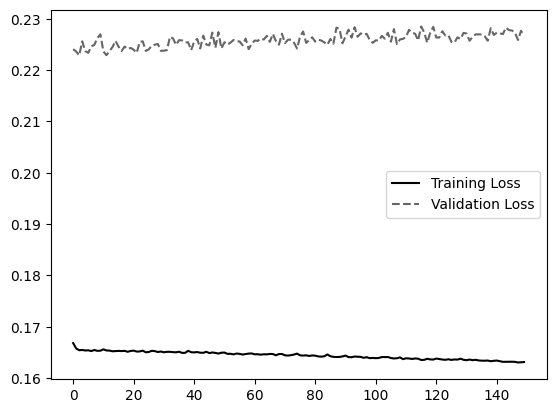

In [114]:
plt.plot(H.history["loss"], label="Training Loss")
plt.plot(H.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [115]:
x_train_pred = autoencoder.predict(teX[:1000])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


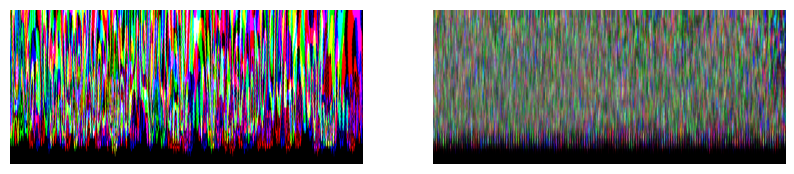

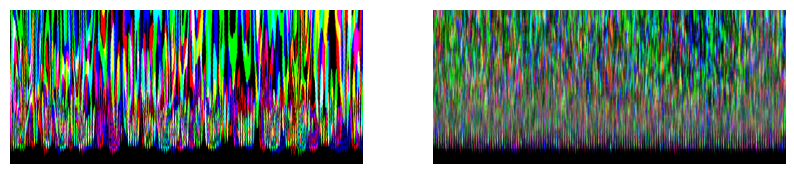

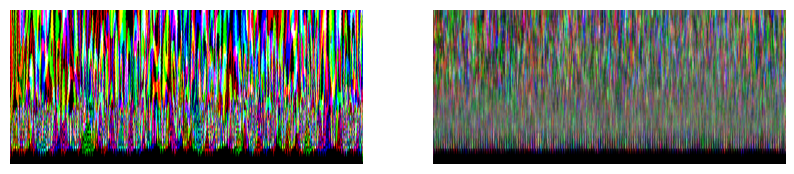

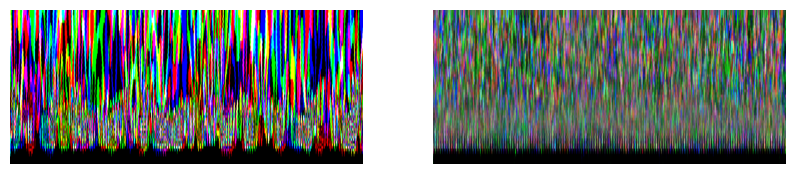

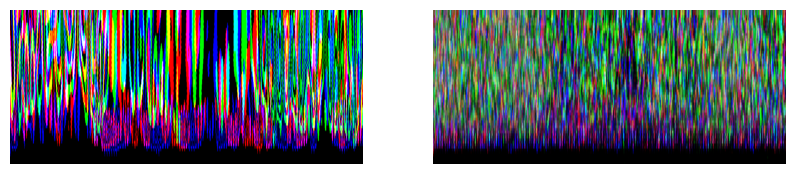

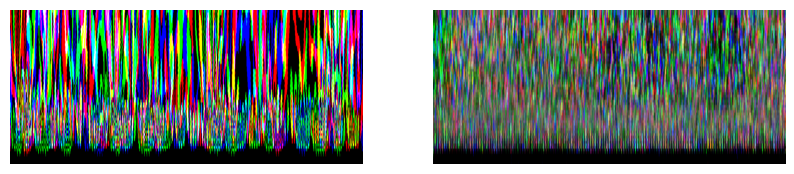

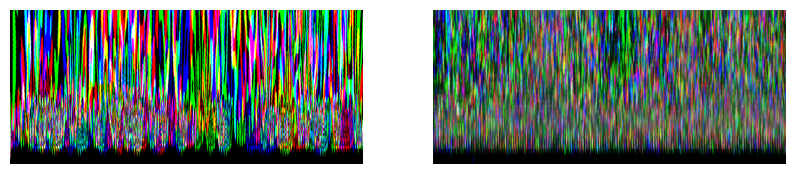

In [118]:
%matplotlib inline
for i in range(7):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,2), dpi=100 )
    ax1.imshow(teX[i*13], origin='lower',aspect='auto')
    ax1.axis("off")
    ax2.imshow(x_train_pred[i*13], origin='lower',aspect='auto')
    plt.axis("off")
    plt.show()